## Using one galaxy bias value -> one clustering map, one lensing map

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pyccl
import healpy as hp
import numpy as np
import matplotlib.pyplot as plt
import math
import os

from coefficient import *

import sys
sys.path.append("./simulation_code/")
#from simulate_des_maps 
import simulate_des_maps as des

In [7]:
def const_pwr(thr_ct,smoothing,nside):

    ### FIXED ###
        
    N = 12*nside**2

    # fixed parameter maps
        
    # there is an issue with this line only when it is inside this function
    %time clustering_maps, lensing_maps = simulate_des_maps(0.3, 0.8, smoothing, nside)
    print(clustering_maps,lensing_maps)
        
    %time v_fixed_c, v0_fixed_c, v1_fixed_c, v2_fixed_c = calc_mf(clustering_maps[0],thr_ct,N,True)
    %time v_fixed_l, v0_fixed_l, v1_fixed_l, v2_fixed_l = calc_mf(lensing_maps[0],thr_ct,N,False)


    # combine fixed clustering and lensing maps
    v_fixed = np.vstack((v_fixed_c,v_fixed_l))
    v0_fixed = np.vstack((v0_fixed_c,v0_fixed_l))
    v1_fixed = np.vstack((v1_fixed_c,v1_fixed_l))
    v2_fixed = np.vstack((v2_fixed_c,v2_fixed_l))

    # mean per threshold value
    mean_v0 = np.zeros(thr_ct)
    mean_v1 = np.zeros(thr_ct)
    mean_v2 = np.zeros(thr_ct)

    for i in range(0,thr_ct):
        mean_v0[i] = mean(v0_fixed[:,i])
        mean_v1[i] = mean(v1_fixed[:,i])
        mean_v2[i] = mean(v2_fixed[:,i])

    # used to find likelihood
    mean_array = np.append(np.append(mean_v0,mean_v1),mean_v2)

    # used to find covariance
    v_all_mean = np.hstack((v0_fixed,v1_fixed,v2_fixed))

    # covariance
    cov = np.cov((v_all_mean.transpose()))


    ### CHANGING ###

    b=10
    omega_m = np.linspace(0.2,0.4,b)
    sigma_8 = (0.8989639361571576)*omega_m + 0.5303108191528527

    v_c = np.zeros((b,thr_ct))
    v0_c = np.zeros((b,thr_ct))
    v1_c = np.zeros((b,thr_ct))
    v2_c = np.zeros((b,thr_ct))

    v_l = np.zeros((b,thr_ct))
    v0_l = np.zeros((b,thr_ct))
    v1_l = np.zeros((b,thr_ct))
    v2_l = np.zeros((b,thr_ct))

    # build maps for varying values of omega and sigma
    for i in range(b):
        c_map,l_map = simulate_des_maps(omega_m[i], sigma_8[i], smoothing, nside)
        v_c[i], v0_c[i], v1_c[i], v2_c[i] = calc_mf(c_map[0],thr_ct,N,True)
        v_l[i], v0_l[i], v1_l[i], v2_l[i] = calc_mf(l_map[0],thr_ct,N,False)
        print(i)

    # combine clustering and lensing arrays    
    v = np.vstack((v_c,v_l))
    v0 = np.vstack((v0_c,v0_l))
    v1 = np.vstack((v1_c,v1_l))
    v2 = np.vstack((v2_c,v2_l))

    # combine MF arrays into one to be used in likelihood calculation
    v_all = np.hstack((v0,v1,v2))

    # calculate S_8
    S_8 = np.zeros(b)
    for i in range(b):
        S_8[i] = sigma_8[i] * (omega_m[i]/0.3)**0.5329788249790618

    # add noise to covariance (only used if necessary)
    cov_w_noise = cov
    for i in range(30):
        for j in range(30):
            cov_w_noise[i][j] = cov[i][j] + np.random.random()*0.0001

    # calculate the likelihood          
    L = np.zeros(b)
    try:
        for i in range(b):
            L[i] = -0.5 * (v_all[i] - mean_array) @ np.linalg.inv(cov) @ (v_all[i] - mean_array)  
    except:
        for i in range(b):
            L[i] = -0.5 * (v_all[i] - mean_array) @ np.linalg.inv(cov_w_noise) @ (v_all[i] - mean_array)

    # calculate the constraining power
    coefficient = np.polyfit(S_8,L,2)

        # plot if desired
        #poly = np.poly1d(coefficient)     
        #new_x = np.linspace(0.5,1.1,20)
        #new_y = poly(new_x)
        #plt.plot(S_8, L, ".", new_x, new_y);

    constraining_power = np.sqrt(-1 / (2*coefficient[0]))
    
    # save data
    c = np.array((thr_ct,smoothing,nside,constraining_power))
    
    # parent directory
    output_path = os.path.join(os.getcwd(), '2_Maps_Faster_Output')
    
    # path for given inputs
    path = os.path.join(output_path, f't{thr_ct}_n{nside}_s{smoothing}')
    
    # check whether directory exists    
    if os.path.isdir(path) is False:
        
        # make new directory
        os.mkdir(path) 
        
    np.savetxt(os.path.join(path, 'c.out'),c)
    
    return constraining_power
    
%time const_pwr(thr_ct=10,smoothing=5,nside=256)

CPU times: user 57.8 s, sys: 923 ms, total: 58.7 s
Wall time: 1min 41s


NameError: name 'clustering_maps' is not defined

In [6]:
def const_pwr(thr_ct,smoothing,nside):
    
    # parent directory
    output_path = os.path.join(os.getcwd(), '2_Maps_Faster_Output')
    
    # path for given inputs
    path = os.path.join(output_path, f't{thr_ct}_n{nside}_s{smoothing}')
    
    # check whether directory exists    
    if os.path.isdir(path) is False:
        
        # make new directory
        os.mkdir(path) 

        ### FIXED ###
        
        N = 12*nside**2

        # fixed parameter maps
        
        # there is an issue with this line only when it is inside this function
        %time clustering_maps, lensing_maps = simulate_des_maps(0.3, 0.8, smoothing, nside)
        print(clustering_maps,lensing_maps)
        
        %time v_fixed_c, v0_fixed_c, v1_fixed_c, v2_fixed_c = calc_mf(clustering_maps[0],thr_ct,N,True)
        %time v_fixed_l, v0_fixed_l, v1_fixed_l, v2_fixed_l = calc_mf(lensing_maps[0],thr_ct,N,False)


        # combine fixed clustering and lensing maps
        v_fixed = np.vstack((v_fixed_c,v_fixed_l))
        v0_fixed = np.vstack((v0_fixed_c,v0_fixed_l))
        v1_fixed = np.vstack((v1_fixed_c,v1_fixed_l))
        v2_fixed = np.vstack((v2_fixed_c,v2_fixed_l))

        # mean per threshold value
        mean_v0 = np.zeros(thr_ct)
        mean_v1 = np.zeros(thr_ct)
        mean_v2 = np.zeros(thr_ct)

        for i in range(0,thr_ct):
            mean_v0[i] = mean(v0_fixed[:,i])
            mean_v1[i] = mean(v1_fixed[:,i])
            mean_v2[i] = mean(v2_fixed[:,i])

        # used to find likelihood
        mean_array = np.append(np.append(mean_v0,mean_v1),mean_v2)

        # used to find covariance
        v_all_mean = np.hstack((v0_fixed,v1_fixed,v2_fixed))

        # covariance
        cov = np.cov((v_all_mean.transpose()))


        ### CHANGING ###

        b=10
        omega_m = np.linspace(0.2,0.4,b)
        sigma_8 = (0.8989639361571576)*omega_m + 0.5303108191528527

        v_c = np.zeros((b,thr_ct))
        v0_c = np.zeros((b,thr_ct))
        v1_c = np.zeros((b,thr_ct))
        v2_c = np.zeros((b,thr_ct))

        v_l = np.zeros((b,thr_ct))
        v0_l = np.zeros((b,thr_ct))
        v1_l = np.zeros((b,thr_ct))
        v2_l = np.zeros((b,thr_ct))

        # build maps for varying values of omega and sigma
        for i in range(b):
            c_map,l_map = simulate_des_maps(omega_m[i], sigma_8[i], smoothing, nside)
            v_c[i], v0_c[i], v1_c[i], v2_c[i] = calc_mf(c_map[0],thr_ct,N,True)
            v_l[i], v0_l[i], v1_l[i], v2_l[i] = calc_mf(l_map[0],thr_ct,N,False)
            print(i)

        # combine clustering and lensing arrays    
        v = np.vstack((v_c,v_l))
        v0 = np.vstack((v0_c,v0_l))
        v1 = np.vstack((v1_c,v1_l))
        v2 = np.vstack((v2_c,v2_l))

        # combine MF arrays into one to be used in likelihood calculation
        v_all = np.hstack((v0,v1,v2))

        # calculate S_8
        S_8 = np.zeros(b)
        for i in range(b):
            S_8[i] = sigma_8[i] * (omega_m[i]/0.3)**0.5329788249790618

        # add noise to covariance (only used if necessary)
        cov_w_noise = cov
        for i in range(30):
            for j in range(30):
                cov_w_noise[i][j] = cov[i][j] + np.random.random()*0.0001

        # calculate the likelihood          
        L = np.zeros(b)
        try:
            for i in range(b):
                L[i] = -0.5 * (v_all[i] - mean_array) @ np.linalg.inv(cov) @ (v_all[i] - mean_array)  
        except:
            for i in range(b):
                L[i] = -0.5 * (v_all[i] - mean_array) @ np.linalg.inv(cov_w_noise) @ (v_all[i] - mean_array)

        # calculate the constraining power
        coefficient = np.polyfit(S_8,L,2)

        # plot if desired
        #poly = np.poly1d(coefficient)     
        #new_x = np.linspace(0.5,1.1,20)
        #new_y = poly(new_x)
        #plt.plot(S_8, L, ".", new_x, new_y);

        constraining_power = np.sqrt(-1 / (2*coefficient[0]))
    
        # save data
        c = np.array((thr_ct,smoothing,nside,constraining_power))
        np.savetxt(os.path.join(path, 'c.out'),c)
    
        return constraining_power
    
%time const_pwr(thr_ct=10,smoothing=5,nside=256)

CPU times: user 59.6 s, sys: 673 ms, total: 1min
Wall time: 1min 39s


NameError: name 'clustering_maps' is not defined

### Steps done individually

In [12]:
# total number of pixels in the image
thr_ct = 10
nside = 512
smoothing=35

N = 12*nside**2

In [13]:
# fixed parameter maps
%time clustering_maps, lensing_maps = simulate_des_maps(0.3, 0.8, smoothing, nside)
%time v_fixed_c, v0_fixed_c, v1_fixed_c, v2_fixed_c = calc_mf(clustering_maps[0],thr_ct,N,True)
%time v_fixed_l, v0_fixed_l, v1_fixed_l, v2_fixed_l = calc_mf(lensing_maps[0],thr_ct,N,False)

CPU times: user 2min 39s, sys: 4.7 s, total: 2min 43s
Wall time: 3min 6s
CPU times: user 54.5 s, sys: 575 ms, total: 55 s
Wall time: 34.4 s
CPU times: user 53 s, sys: 507 ms, total: 53.5 s
Wall time: 32.9 s


In [14]:
# combine clustering and lensing maps
v_fixed = np.vstack((v_fixed_c,v_fixed_l))
v0_fixed = np.vstack((v0_fixed_c,v0_fixed_l))
v1_fixed = np.vstack((v1_fixed_c,v1_fixed_l))
v2_fixed = np.vstack((v2_fixed_c,v2_fixed_l))

# mean per threshold value
mean_v0 = np.zeros(thr_ct)
mean_v1 = np.zeros(thr_ct)
mean_v2 = np.zeros(thr_ct)

for i in range(0,thr_ct):
    mean_v0[i] = mean(v0_fixed[:,i])
    mean_v1[i] = mean(v1_fixed[:,i])
    mean_v2[i] = mean(v2_fixed[:,i])

# used to find likelihood
mean_array = np.append(np.append(mean_v0,mean_v1),mean_v2)

# used to find covariance
#v_all_mean = np.concatenate((v0_fixed,v1_fixed,v2_fixed))
v_all_mean = np.hstack((v0_fixed,v1_fixed,v2_fixed))

# covariance
cov = np.cov((v_all_mean.transpose()))

In [15]:
b=10
perpendicular_slope = 0.8989639361571576
y_intercept = 0.5303108191528527

omega_m = np.linspace(0.2,0.4,b)
sigma_8 = perpendicular_slope*omega_m + y_intercept

In [16]:
v_c = np.zeros((b,thr_ct))
v0_c = np.zeros((b,thr_ct))
v1_c = np.zeros((b,thr_ct))
v2_c = np.zeros((b,thr_ct))

v_l = np.zeros((b,thr_ct))
v0_l = np.zeros((b,thr_ct))
v1_l = np.zeros((b,thr_ct))
v2_l = np.zeros((b,thr_ct))

#c_map = np.zeros((b,len(clustering_maps),N)) 
#l_map = np.zeros((b,len(lensing_maps),N))

for i in range(b):
    #c_map[i],l_map[i] = simulate_des_maps(omega_m[i], sigma_8[i], smoothing, nside)
    #v[i],v0[i],v1[i],v2[i] = calc_mf_2maps(c_map[i][0],l_map[i][0],thr_ct,N)
    
    c_map,l_map = simulate_des_maps(omega_m[i], sigma_8[i], smoothing, nside)
    v_c[i], v0_c[i], v1_c[i], v2_c[i] = calc_mf(c_map[0],thr_ct,N,True)
    v_l[i], v0_l[i], v1_l[i], v2_l[i] = calc_mf(l_map[0],thr_ct,N,False)
    
    print(i)


0
1
2
3
4
5
6
7
8
9


In [17]:
v = np.vstack((v_c,v_l))
v0 = np.vstack((v0_c,v0_l))
v1 = np.vstack((v1_c,v1_l))
v2 = np.vstack((v2_c,v2_l))

#v_all = np.concatenate((np.concatenate(v0),np.concatenate(v1),np.concatenate(v2)),axis=1)
v_all = np.hstack((v0,v1,v2))

In [18]:
S_8 = np.zeros(b)
for i in range(b):
    S_8[i] = sigma_8[i] * (omega_m[i]/0.3)**0.5329788249790618  # exponent value found in plotting notebook        

In [19]:
# add noise to covariance
cov_w_noise = cov
for i in range(30):
    for j in range(30):
        cov_w_noise[i][j] = cov[i][j] + np.random.random()*0.0001
    
# calculate the likelihood          
L = np.zeros(b)
try:
    for i in range(b):
        L[i] = -0.5 * (v_all[i] - mean_array) @ np.linalg.inv(cov) @ (v_all[i] - mean_array)  
except:
    for i in range(b):
        L[i] = -0.5 * (v_all[i] - mean_array) @ np.linalg.inv(cov_w_noise) @ (v_all[i] - mean_array)

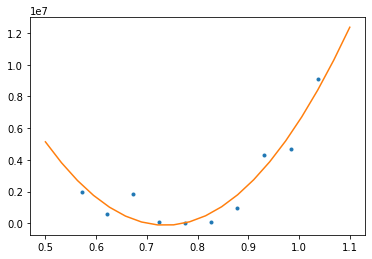

In [20]:
coefficient = np.polyfit(S_8,L,2)
poly = np.poly1d(coefficient)     
new_x = np.linspace(0.5,1.1,20)
new_y = poly(new_x)
plt.plot(S_8, L, ".", new_x, new_y);

In [21]:
constraining_power = sqrt(-1 / (2*coefficient[0]))
constraining_power

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in sqrt
  """Entry point for launching an IPython kernel.


nan

In [22]:
# save data

# parent directory
output_path = os.path.join(os.getcwd(), '2_Maps_Faster_Output')
    
# path for given inputs
path = os.path.join(output_path, f't{thr_ct}_n{nside}_s{smoothing}')

try:
    os.mkdir(path) 
except:
    pass

c = np.array((thr_ct,smoothing,nside,constraining_power))
np.savetxt(os.path.join(path, 'c.out'),c)

### All steps - doesn't rerun if data exists

In [23]:
# plot smoothing vs. constraining power
smoothing_array = [10,15,20,25,30,35]#np.linspace(5,60,12)
thr_ct = 10
nside = 512
c = np.zeros(len(smoothing_array))

# parent directory
output_path = os.path.join(os.getcwd(), '2_Maps_Faster_Output')
    
#for i in smoothing_array:
for i,smoothing in enumerate(smoothing_array):
    path = os.path.join(output_path, f't{thr_ct}_n{nside}_s{smoothing}')
    output = np.loadtxt(os.path.join(path, 'c.out'))
    c[i] = output[3]
    
c

array([1.44043357e-05, 1.44043357e-05,            nan,            nan,
       8.03731016e-05,            nan])

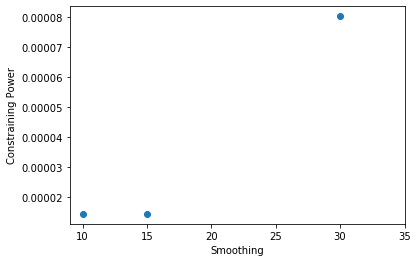

In [24]:
plt.plot(smoothing_array,c,'o')
plt.xlabel('Smoothing')
plt.xticks(smoothing_array)
plt.ylabel('Constraining Power');